# Full-Waveform Inversion (FWI) expanded

This notebook is based in the third in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. This aplication isolates the setup of the fwi parameters in an easy to use way, allowing for a faster changing of initial parameters, facilitating the testing of the fwi aplications.


In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

## Setting the FWI parameters

##### The following parameters are needed to apply the FWI at a given preset:
true_model, fwi_model0, nshots, nreceivers, src_coordinates, rec_coordinates, source_locations, geometry, solver, fwi_iterations

True Model:


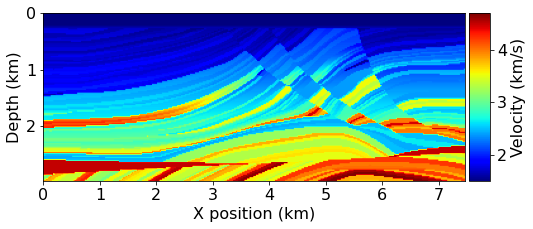

FWI Model 0:


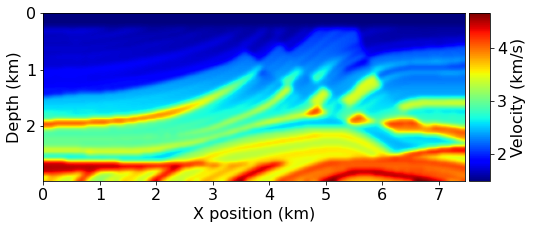

Sources and receivers positions:


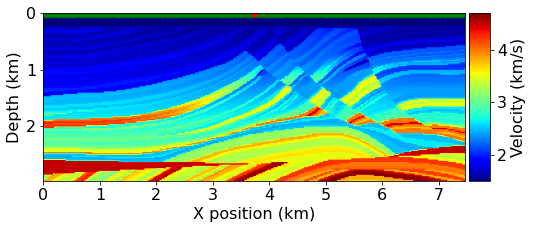

Sources locations:


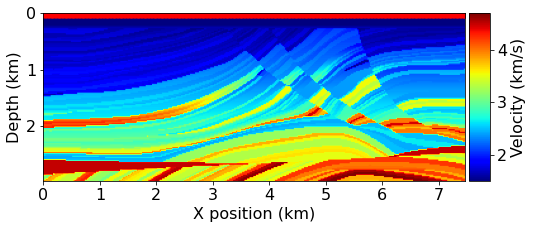

Geometry:


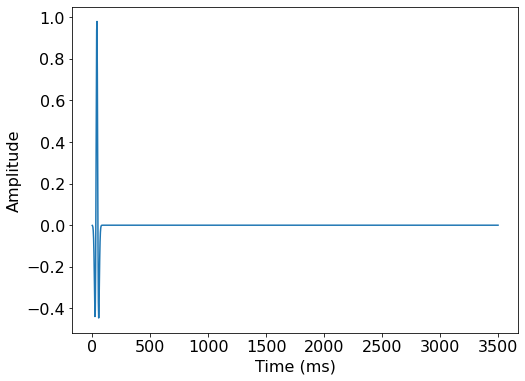

In [2]:
from fwi_prep import demo_fwi

# Setup the true model and all other simulation objects from a preset
model, model0, nshots, nreceivers, src_coordinates, rec_coordinates, source_locations,\
geometry, solver, fwi_iterations = demo_fwi('m2d', show_plots=True)

# Full-Waveform Inversion


## Formulation

Full-waveform inversion (FWI) aims to invert an accurate model of the discrete wave velocity, $\mathbf{c}$, or equivalently the square slowness of the wave, $\mathbf{m} = \frac{1}{\mathbf{c}^2}$, from a given set of measurements of the pressure wavefield $\mathbf{u}$. This can be expressed as the following optimization problem [1, 2]:

\begin{aligned}
	\mathop{\hbox{minimize}}_{\mathbf{m}} \Phi_s(\mathbf{m})&=\frac{1}{2}\left\lVert\mathbf{P}_r
	\mathbf{u} - \mathbf{d}\right\rVert_2^2 \\
	\mathbf{u} &= \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^T \mathbf{q}_s, 
\end{aligned}

where $\mathbf{P}_r$ is the sampling operator at the receiver locations, $\mathbf{P}_s^T$ is the injection operator at the source locations, $\mathbf{A}(\mathbf{m})$ is the operator representing the discretized wave equation matrix, $\mathbf{u}$ is the discrete synthetic pressure wavefield, $\mathbf{q}_s$ is the corresponding pressure source and $\mathbf{d}$ is the measured data. It is worth noting that $\mathbf{m}$ is the unknown in this formulation and that multiple implementations of the wave equation operator $\mathbf{A}(\mathbf{m})$ are possible. 

We have already defined a concrete solver scheme for $\mathbf{A}(\mathbf{m})$ in the first tutorial, including appropriate implementations of the sampling operator $\mathbf{P}_r$ and source term $\mathbf{q}_s$.

To solve this optimization problem using a gradient-based method, we use the
adjoint-state method to evaluate the gradient $\nabla\Phi_s(\mathbf{m})$:

\begin{align}
 \nabla\Phi_s(\mathbf{m})=\sum_{\mathbf{t} =1}^{n_t}\mathbf{u}[\mathbf{t}] \mathbf{v}_{tt}[\mathbf{t}] =\mathbf{J}^T\delta\mathbf{d}_s,
\end{align}

where $n_t$ is the number of computational time steps, $\delta\mathbf{d}_s = \left(\mathbf{P}_r \mathbf{u} - \mathbf{d} \right)$ is the data residual (difference between the measured data and the modelled data), $\mathbf{J}$ is the Jacobian operator and $\mathbf{v}_{tt}$ is the second-order time derivative of the adjoint wavefield solving:

\begin{align}
 \mathbf{A}^T(\mathbf{m}) \mathbf{v} = \mathbf{P}_r^T \delta\mathbf{d}.
\end{align}

We see that the gradient of the FWI function is the previously defined imaging condition with an extra second-order time derivative. We will therefore reuse the operators defined previously inside a Devito wrapper.

## FWI gradient operator

To compute a single gradient $\nabla\Phi_s(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to encode a similar procedure to the previous imaging tutorial as our gradient calculation:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

In [3]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

In [4]:
# Create FWI gradient kernel (with progress bar)
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver
import scipy

from ipywidgets import IntProgress
from IPython.display import display
import time

def fwi_gradient(vp_in):
    start = time.time()
    
    # Instantiate the progress bar
    pb = IntProgress(min=0, max=nshots)
    display(pb)

    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
        # Advance the progress bar
        pb.value += 1
        
    finish = time.time()
    print("Elapsed time: "+str(finish-start)+"s")
    return objective, grad

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the gradient alongside the model perturbation and the effect of the gradient update on the model.

In [5]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
print('Objective value is %f' % (ff))

IntProgress(value=0, max=301)

Elapsed time: 257.01976585388184s
Objective value is 6798436.721630


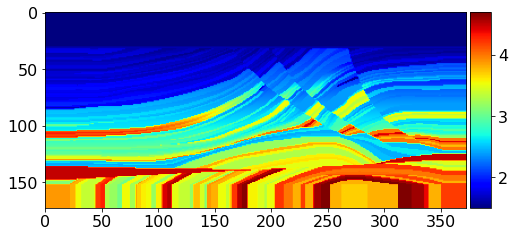

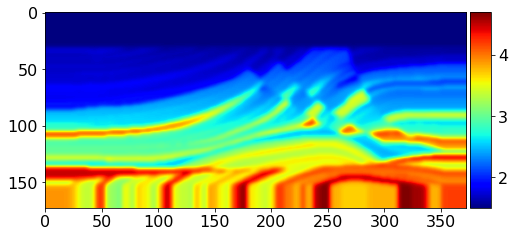

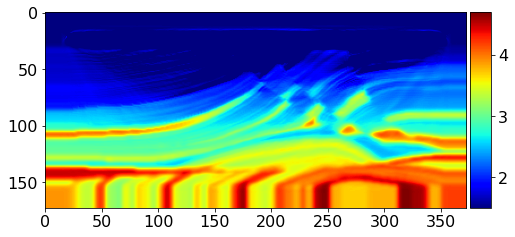

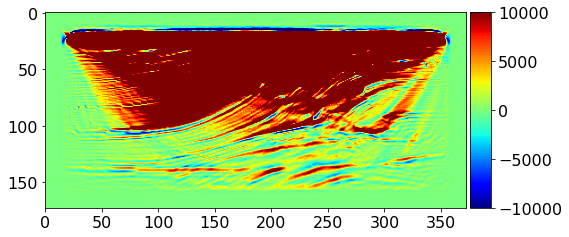

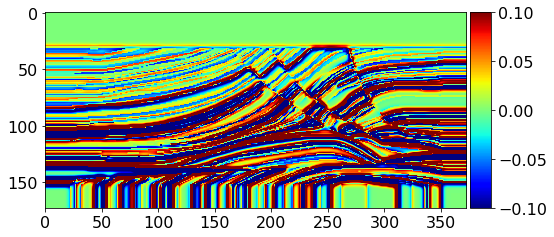

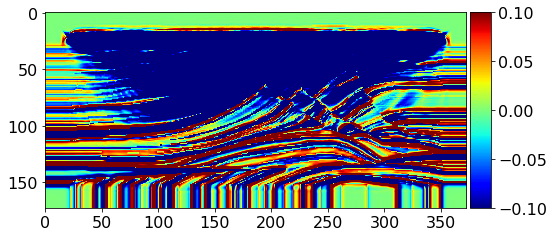

In [9]:
#NBVAL_IGNORE_OUTPUT
from devito import mmax
from examples.seismic import plot_image
from devito.builtins import mmin, mmax

# Show the true model
plot_image(model.vp.data, vmin=mmin(model.vp), vmax=mmax(model.vp), cmap="jet")

# Show the model before the update
plot_image(model0.vp.data, vmin=mmin(model0.vp), vmax=mmax(model0.vp), cmap="jet")

# Show what the update does to the model
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=mmin(model0.vp), vmax=mmax(model0.vp), cmap="jet")

# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# And also the difference between the true and updated model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")
plot_image(model0.vp.data + alpha*update.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

In [7]:
from sympy import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin, vmax):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [ ]:
#NBVAL_SKIP

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / mmax(direction)
    
    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction, mmin(model0.vp), mmax(model0.vp))
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

In [ ]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, demo_model, AcquisitionGeometry, plot_velocity, plot_perturbation

# Plot inverted velocity model
plot_velocity(model0)

In [ ]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## References

[1] _Virieux, J. and Operto, S.: An overview of full-waveform inversion in exploration geophysics, GEOPHYSICS, 74, WCC1–WCC26, doi:10.1190/1.3238367, http://library.seg.org/doi/abs/10.1190/1.3238367, 2009._

[2] _Haber, E., Chung, M., and Herrmann, F. J.: An effective method for parameter estimation with PDE constraints with multiple right hand sides, SIAM Journal on Optimization, 22, http://dx.doi.org/10.1137/11081126X, 2012._

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the Intel® HPC Developer Conference 2017.</sup>